# Modules and Helper Functions

In [2]:
#load required modules
%matplotlib inline
import sys
import dill
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import pandas as pd
import datetime
from sodapy import Socrata
import requests
import numpy as np
import re
import seaborn as sns
import  simplejson as json
import scipy
import sklearn
from datetime import timedelta, date, time, datetime as dt
import datetime
import shapely
import shapely.geometry as geom
import holidays
import psycopg2
from io import StringIO
from ediblepickle import checkpoint
import string
import ipywidgets


In [103]:
#create functions to aplly to pandas 

lat_long=re.compile('(-\d*.?\.\d*.?),\s(\d*.?\.\d*.?)]')
from dateutil import tz
def local2utc(d):
    from_zone=tz.gettz('America/New_York')
    to_zone=tz.gettz('UTC')
    d.replace(tzinfo=from_zone)
    return d.astimezone(to_zone)

def isdem(permnumber):
    #if a permit starts with DEM its a demolition permit
    dem=re.compile('DEM')
    if dem.match(permnumber)==None:
        return False
    else:
        return True
    
def isuse(permnumber):
    #if a permit starts with USE  its a use permit
    use=re.compile('USE')
    if use.match(permnumber)==None:
        return False
    else:
        return True
def make_lower(nh):
    #make neighborhood names lowercase to ensure match
    if type(nh)==str:
        return nh.lower()
    else:
        return nh
    
def is_drug_charge(row):
    #determine if a drug charge has cds in description or is coded 87 (narcotics)
    cds=re.compile('cds',re.I)
    try:
        if row['incidento'][0:1]=='87':
            return True
        elif cds.search(row['chargedescription'])!=None:
            return True
        else:
            return False
    except:
        return False

def pull_year(dt_obj):
    #determine year from date for group by function
    return dt_obj.year

def pull_date(dt_obj):
    #determine year from date for group by function
    return dt_obj.date

def r2(fit, x, y):
    #calculate R2 from a fit and the input data
    p=np.poly1d(fit)
    yhat=p(x)
    ybar=np.sum(y)/len(y)
    ssres=np.sum((yhat-y)**2)
    sstotal=np.sum((y-ybar)**2)
    rsquared=1-ssres/sstotal
    return rsquared

def str2dt(s):
    return dt.strptime(s,'%Y-%m-%dT%H:%M:%SZ')

def str2time(s):
    return dt.strptime(s,'%H:%M:%S %p').time()

def label_coord(coord):
    #lookup grid no from coordinates, can be applied to pandas
    if coord in coord_labels.keys():
        return coord_labels[coord]
    else:
        return np.nan

def label2coord(lab):
    #lookup coordinates from grid no
    if np.isfinite(lab):
        return tuple(zip(labels_coord[lab]))
    else:
        return tuple(zip(tuple((np.nan,np.nan))))   
    
def daterange(start_date, end_date):
    #create a linear range of dates
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

def hourrange(start_date, end_date):
    for n in range(int ((end_date-start_date).total_seconds()/60**2)):
        yield start_date+timedelta(hours=n)

def nan2zero(o):
    #convert nan to zero, typicaly applies if nan is created from a merge between records
    #and the gid attributes dataframe if none of the record contain the grid point
    if np.isnan(o):
        return  0
    else:
        return o
    
def pull_lat(location):
    #pull latitude from location given in dict format, check if saved in csv file as string
    if type(location)==str:
        location=lat_long.search(location)
    try:
        return float(location.groups(0)[0])
    except Exception:
        return np.nan

def pull_lon(location):
    #pull longitude from location given in dict format, check if saved in csv file as string
    if type(location)==str:
        location=lat_long.search(location)
    try:
        return float(location.groups(0)[1])
    except Exception:
        return np.nan

def gc_distance(lat1, lon1, lat2, lon2):
    #calculate distance between two coordinateds using the haversine formula
    lat1=lat1*2*np.pi/360
    lat2=lat2*2*np.pi/360
    lon1=lon1*2*np.pi/360
    lon2=lon2*2*np.pi/360
    dphi=lat1-lat2
    dlambda=lon1-lon2
    arc=2*np.arcsin((np.sin(dphi/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(dlambda/2)**2)**.5)
    return 3959*arc

def place_on_grid(df, location_key):
    #convert latitude and longitude given in a location dict into the grid
    df['latitude']=df[location_key].apply(pull_lat)
    df['longitude']=df[location_key].apply(pull_lon)
    df['lat_bin']=pd.cut(df['latitude'],bins=lats,labels=lat_label)
    df['lon_bin']=pd.cut(df['longitude'],bins=lons,labels=lon_label)
    df['grid_no']=df.apply(lambda x: label_coord(tuple((x['lat_bin'], x['lon_bin']))), axis=1)
    df['grid_coords']=df['grid_no'].apply(label2coord)
    return df

def obj_min_dist(a,b):
    return(a.distance(b)/1609.2446469)

# Load Data From APIs

## Dataset Data from open Baltimore

### Define functions to pickle the data from the API's

In [210]:
from ediblepickle import checkpoint
import string

def r2p_pickler(df,f):
    df.to_csv(f,encoding='UTF-8')
    
def r2p_unpickler(f):
    return pd.DataFrame.from_csv(f)

@checkpoint(key=string.Template('/home/vagrant/Baltimore_vacants_crime/{0}.csv'), 
            pickler=r2p_pickler, unpickler=r2p_unpickler, refresh=False)
def records_to_pandas(name,ds,lim):
    results = client.get(ds,limit=lim)
    
    return pd.DataFrame.from_records(results)



In [7]:
secrets = json.loads(open('apikey.json.nogit','r').read())
client = Socrata("data.baltimorecity.gov", secrets['app_token'])

### Victim Based Crime Data

In [ ]:
#download the victim based crime dataset make into dataframe, make 
#crimedate into a datetime object, make neighborhood lowercase
vict_crime=records_to_pandas('vict_crime',"4ih5-d5d5",500000)
vict_crime['crimedate']=pd.to_datetime(vict_crime['crimedate'],yearfirst=True)
vict_crime['neighborhood']=vict_crime['neighborhood'].apply(make_lower)


### Arrests Data

In [209]:
#Download arrest data, determine if it is a drug charge, convert date to 
#datetime object, make neighborhood lower case
arrest_df=records_to_pandas('arrests','icjs-e3jg',1600000)
arrest_df.is_drugs=arrest_df.apply(is_drug_charge, axis=1)
arrest_df.arrestdate=pd.to_datetime(arrest_df['arrestdate'],yearfirst=True)
arrest_df['neighborhood']=arrest_df['name1'].apply(make_lower)

### Housing Permit Data

In [ ]:
house_perm_df=pd.DataFrame.from_csv('housing_permits.csv')

In [ ]:
#download housing permits, determine if the are use or demolition permits,
#make permit date into a datetime, make the neighborhood lowercase
perm_res=client.get('9t78-k3wf',limit=600000)
house_perm_df=records_to_pandas('housing_permits','9t78-k3wf',600000)
house_perm_df['dateissue']=pd.to_datetime(house_perm_df.dateissue,yearfirst=True)
house_perm_df['isdem']=house_perm_df.casenum.apply(isdem)
house_perm_df['isuse']=house_perm_df.casenum.apply(isuse)
house_perm_df['neighborhood']=house_perm_df.neighborhood.apply(make_lower)
house_perm_df['latitude']=house_perm_df['location'].apply(pull_lat)
house_perm_df['longitude']=house_perm_df['location'].apply(pull_lon)

### Vacant Buildings Data

In [ ]:
#Dowload vacant house dataset, make neighborhood lowercase
vac_df=records_to_pandas('vacants','rw5h-nvv4',20000)
vac_df.neighborhood=vac_df.neighborhood.apply(make_lower)
vac_df['latitude']=vac_df['location'].apply(pull_lat)
vac_df['longitude']=vac_df['location'].apply(pull_lon)

### LIquor License Data

In [ ]:
liquor_locs=records_to_pandas('liquor','g2jf-x8pp',10000)
#liquor_locs['latitude']=liquor_locs['location_1'].apply(pull_lat)
#liquor_locs['longitude']=liquor_locs['location_1'].apply(pull_lon)

### CCTV Locations

In [ ]:
cctv_locs = records_to_pandas('cctv', 'h3bk-xcnf', 10000)
cctv_locs.head(40)

## Baltimore Open Data (GIS)

### GIS Data Pickler

In [ ]:
def json_pickler(out_dict,f):
    json.dumps(out_dict,f,encoding='UTF-8')
    
def json_unpickler(f):
    return json.loads(open(f).read())

@checkpoint(key=string.Template('/home/vagrant/Baltimore_vacants_crime/{0}.json'),pickler=json_pickler,
           unpickler=json_unpickler, refresh='False')
def get_geojson(name,ds):
    loc='http://gis-baltimore.opendata.arcgis.com/datasets/'+ds+'.geojson'
    return requests.get(loc,secrets['app_token']).json()['features']

## download GIS Data

In [ ]:
## download location of parks and zoning data
parks=get_geojson('parks','583030920e7f41089e01aff63bd305e6_0')
ez=get_geojson('ez','90712f770cac495c8c3e1659e5bf4d71_0')
ezta=get_geojson('ezta','506abeca72cb4365bef0a1f3bbdad7b7_0')
zoning=get_geojson('zoning','5645866640f6436f8f37de3d3fbcbbb3_0')
real_property=get_geojson('real_property','b41551f53345445fa05b554cd77b3732_0')
house_typology=get_geojson('house_typ','7333122beb68414e9e7744f2dd986578_0')
leg_districts=get_geojson('leg_dist','1019cf2276f24c1f98de5696d68f449d_0')
trees=client.get('xfdv-p3cc',limit=100000)

In [ ]:
ezta[1]

### Convert GIS Data into dataframe with max and min lat and long, features (if applicable) and polygon

#### Vegitated Area (no Features, Yes or NO)

In [ ]:
tree_poly=[]
for feat in trees:
    coords=feat['the_geom']['coordinates']
    for shape in coords:
        tuple_list=[tuple(pt) for pt in shape[0]]
        out_dict={}
        out_dict['poly']=shapely.geometry.Polygon(tuple_list)
        out_dict['max_lon']=max(tuple_list)[0]
        out_dict['min_lon']=min(tuple_list)[0]
        out_dict['max_lat']=max(tuple_list,key=lambda (x,y):(y,x))[1]
        out_dict['min_lat']=min(tuple_list,key=lambda (x,y):(y,x))[1]
        tree_poly.append(out_dict)
tree_df=pd.DataFrame(tree_poly)

#### Functions if the GEO_JSON should create a polygon or a point

In [ ]:
def make_poly_and_bounds(shape,prop_dict):
    tuple_list=[tuple(pt) for pt in shape]
    out_dict={}
    out_dict['properties']=prop_dict
    out_dict['poly']=shapely.geometry.Polygon(tuple_list)
    out_dict['max_lon']=max(tuple_list)[0]
    out_dict['min_lon']=min(tuple_list)[0]
    out_dict['max_lat']=max(tuple_list,key=lambda (x,y):(y,x))[1]
    out_dict['min_lat']=min(tuple_list,key=lambda (x,y):(y,x))[1]
    return out_dict

@checkpoint(string.Template('/home/vagrant/Baltimore_vacants_crime/{1}df_from_json.pkd'),refresh=False)
def df_w_polygons_from_geojson(json_dict,key,properties=[]):
    poly=[]
    for feat in json_dict:
        prop_dict={}
        if len(properties)>0:
            for p in properties:
                prop_dict[p]=feat['properties'][p]
        if feat['geometry']['type']=='Polygon':
            poly.append(make_poly_and_bounds(feat['geometry']['coordinates'][0]
                                             ,prop_dict))
        else:
            for shape in feat['geometry']['coordinates']:
                poly.append(make_poly_and_bounds(shape[0],
                                                 prop_dict))
    return pd.DataFrame(poly)

@checkpoint(string.Template('/home/vagrant/Baltimore_vacants_crime/{1}df_from_json.pkd'))
def df_w_rep_points_from_geojson(json_dict,key,properties=[]):
    point=[]
    for feat in json_dict:
        prop_dict={}
        if len(properties)>0:
            for p in properties:
                prop_dict[p]=feat['properties'][p]
        if feat['geometry']['type']=='Polygon':
            coords=feat['geometry']['coordinates'][0]
        else:
            coords=feat['geometry']['coordinates'][0][0]
        tuple_list=[tuple(pt) for pt in coords]
        out_dict={}
        poly=shapely.geometry.Polygon(tuple_list)
        pt=poly.representative_point().coords[0]
        prop_dict['latitude']=pt[0]
        prop_dict['longitude']=pt[1]
        point.append(prop_dict)
    return pd.DataFrame(point)

In [ ]:
leg_dist_df=df_w_polygons_from_geojson(leg_districts,'leg_dist')
park_df=df_w_polygons_from_geojson(parks,['ACRES'])
ez_df=df_w_polygons_from_geojson(ez,'ez')
ezta_df=df_w_polygons_from_geojson(ezta,'ezta')
zoning_df=df_w_polygons_from_geojson(zoning,'zoning',['Zoning'])
rp_df=df_w_rep_points_from_geojson(real_property,'rp',
                                   ['TAXBASE','USEGROUP','DWELUNIT',
                                    'FULLCASH','ZONECODE','OWNER_1'])
house_typ_df=df_w_polygons_from_geojson(house_typology,'ht',['CSP1214_CI','VSP1214_CI','HuSQmi14CI',
                                                        'PCIn_14_CI','CFC1214_CI','PHOO_Hu_14',
                                                        'HMT','CVAC_14_CI','CVaLT14_CI','MSP1214_CI',
                                                        'PCIn_14_CI'
                                                       ])

In [ ]:
len(ezta)

### API for non-baltimore Data (Sunset and Weather)

In [ ]:
sun_df=pd.DataFrame.from_csv('baltimore_sunset.csv')
weather_df=pd.DataFrame.from_csv('bwi_weather.csv')

In [ ]:
start_date = date(2012, 1, 1)
end_date = date.today()
days=(end_date-start_date).days
day_list=[start_date+timedelta(d) for d in xrange(days)]
sun_info=list()
for sd in day_list:
    param={'lat':39.25,'lng':-76.6,'date':sd.strftime('%Y-%m-%d')}
    resp=requests.get('https://api.sunrise-sunset.org/json?',params=param)
    rdict=resp.json()
    sun_dict=rdict['results']
    sun_dict['date']=sd
    sun_info.append(sun_dict)
sun_df=pd.DataFrame(sun_info)
sun_df.to_csv('baltimore_sunset.csv')  

In [ ]:
for years in range(2012,2018):
    param={'stid':'kbwi','start':date(years,1,1).strftime('%Y%m%d%H%M'),
       'end':(date(years,12,31)).strftime('%Y%m%d%H%M'),
      'token':'34d783ecbaa3414e8f942227b22c1ab0'}
    weath_req=requests.get('https://api.mesowest.net/v2/stations/timeseries?',params=param)
    if years==2012:
        wdict=weath_req.json()['STATION'][0]['OBSERVATIONS']
        weather_df=pd.DataFrame(wdict)
        print(weather_df.columns)
    else:
        wdict=weath_req.json()['STATION'][0]['OBSERVATIONS']
        weather_df.append(pd.DataFrame(wdict))
weather_df=weather_df[['date_time','air_temp_set_1','precip_accum_24_hour_set_1','precip_accum_one_hour_set_1','weather_condition_set_1d']]
weather_df.to_csv('bwi_weather.csv')

In [ ]:
## Begin DataFrame PreProcessing

Read Static Data from CSV files to avoid iternet bottleneck

# Place geographic inputs on a grid and make dataframe

## Setup Grid

### make .1mile x .1 mile grid

In [11]:
bmap = Basemap(llcrnrlon=-76.72,llcrnrlat=39.195,urcrnrlon=-76.52,urcrnrlat=39.375,projection='lcc', lat_0=39.25, lon_0=-76.65)
#bmap.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
lons, lats, x, y = bmap.makegrid(107, 124, returnxy=True)
lats=sorted(lats[:,0])
lons=sorted(lons[0,:])
lon_label=list()
for i,lon in enumerate(lons):
    if i>0:
        lon_label.append((lons[i]+lons[i-1])/2)
lat_label=list()
for i,lat in enumerate(lats):
    if i>0:
        lat_label.append((lats[i]+lats[i-1])/2)

In [12]:
lat_step=np.mean([lat_label[i+1]-lat_label[i] for i in xrange(122)])
print(lat_step)
lon_step=np.mean([lon_label[i+1]-lon_label[i] for i in xrange(105)])
print(lon_step)

0.00146383012335
0.0018836460011


In [ ]:
len(lats)=

### Create Data Frame with Latitude and Longitude point and polygon represneting grid of all locations in the city

In [ ]:
def check_in_city(point):
    pt=geom.Point(point[0],point[1])
    return any([poly.contains(pt) for poly in leg_dist_df['poly']])

def grid_box(point):
    return geom.Polygon([(point[0]-lon_step/2,point[1]+lat_step/2),
                        (point[0]+lon_step/2,point[1]+lat_step/2),
                        (point[0]+lon_step/2,point[1]-lat_step/2),
                        (point[0]-lon_step/2,point[1]-lat_step/2),
                        (point[0]-lon_step/2,point[1]+lat_step/2)])
import itertools
#identify the set of nodes that are in the city
plt.figure(figsize=(24,24))
coord_set=[{'lon':a[0],'lat':a[1],'point':geom.Point(a),'poly':grid_box(a)}
            for a in itertools.product(lon_label,lat_label) if check_in_city(a)]
coord_set_df=pd.DataFrame(coord_set)

### use GeoJSON data to assign information to coordinates data frame for polygons

In [ ]:
def check_contains(poly,point):
    #Check if a point is in a polygon using shapely
    return poly.contains(point)
def find_properties(layer,row_tup):
    #Slice the dataframe of shapely polygons based on bounding box of each polygon.
    #Search all polygons whose bounding box contains the point to determine which polygon 
    #contains the point.  Assign attributes of the polygon to the point.
    row=row_tup[1]
    out_dict={}
    layer_sliced = layer.loc[(layer['max_lat']>row['lat']) & 
                            (layer['min_lat']<row['lat']) & 
                            (layer['max_lon']>row['lon']) &
                            (layer['min_lon']<row['lon']),
                            :].copy()
    if layer_sliced.shape[0]==0:
        return {'I':row_tup[0],'properties':False}
        
    else:
        for feat in layer_sliced.iterrows():
            if feat[1]['poly'].contains(row['point']):
                if 'properties' in feat[1]:
                    out_dict=feat[1]['properties'].copy()
                    out_dict['I']=row_tup[0]
                    return out_dict
                else:
                    return {'I':row_tup[0],'properties':True}
        return {'I':row_tup[0],'properties':False}
                

In [ ]:
@checkpoint(key=string.Template('/home/vagrant/Baltimore_vacants_crime/{1}.pkd'),refresh=True)
def coord_properties_from_polygons(layer,frame_id):
    cp_dict_list=[]
    for row in coord_set_df.iterrows():
        a=(find_properties(layer,row))
        cp_dict_list.append(a)
    return pd.DataFrame(cp_dict_list)

ht_coord_df=coord_properties_from_polygons(house_typ_df,'ht_coord')
park_coord_df=coord_properties_from_polygons(park_df,'park_coord')
zoning_coord_df=coord_properties_from_polygons(zoning_df,'zoning_coord')
ez_coord_df=coord_properties_from_polygons(ez_df,'ez_coord')
ezta_coord_df=coord_properties_from_polygons(ezta_df,'ezta_coord')
tree_coord_df=coord_properties_from_polygons(tree_df,'tree_coord')

In [ ]:
#Rename the columns to more descriptive names
ez_coord_df.rename(columns={'properties':'ent_zone'},inplace=True)
ezta_coord_df.rename(columns={'properties':'targ_ent_zone'},inplace=True)
tree_coord_df.rename(columns={'properties':'vegetated'},inplace=True)
park_coord_df.rename(columns={'properties':'park'},inplace=True)

ht_coord_df.rename(columns={'CSP1214_CI':'residential_sales',
                    'VSP1214_CI':'var_res_sale_price',
                    'MSP1214_CI':'med_res_sale_price',
                    'CVAC_14_CI':'vac_parcels',
                    'PCIn_14_CI':'perc_com_ind',
                    'HMT':'housing_class',
                    'PHOO_Hu_14':'percent_owner_occupied',
                    'CVaLT14_CI':'vac_lots'
                    },inplace=True)


### Combine the attributes from GIS onto a single data frame

In [ ]:
@checkpoint(key='/home/vagrant/Baltimore_vacants_crime/coord_from_gis_poly.pkd',refresh=False)
def join_columns():
    rsuf=['ht','park','zoning','ent_zone','ent_zone_ta','tree']
    layers=[ht_coord_df,park_coord_df,zoning_coord_df,ez_coord_df,ezta_coord_df,tree_coord_df]
    ct=0
    c2=coord_set_df.copy()
    for i,layer in enumerate(layers):
        layer.reindex(columns=['I'])
        c2=c2.join(layer,rsuffix=rsuf[i],how='inner')
    return c2

coord_and_poly=join_columns()
coord_and_poly.drop(['point','poly'],axis=1,inplace=True)
coord_and_poly.shape      
    

## Aggregate Datasets Over the gird

### Housing Permits

##### Place permit data on grid

In [183]:
locations_re=re.compile(r'coordinates\'\: \[(-\d.*?), (\d.*?)\]')

def pull_lat(val):
    if isinstance(val,dict):
        return val['coordinates'][1]
    else:
        try:
            return float(locations_re.search(val).groups(0)[1])
        except Exception:
            return np.nan
    
def pull_lon(val):
    if isinstance(val,dict):
        return val['coordinates'][0]
    else:
        try:
            return float(locations_re.search(val).groups(0)[0])
        except Exception:
            return np.nan
        
def place_on_grid(df, loc_col):
    df['latitude']=df[loc_col].apply(pull_lat)
    df['longitude']=df[loc_col].apply(pull_lon)
    df['lat_label']=pd.cut(df['latitude'],bins=lats,labels=lat_label)
    df['lon_label']=pd.cut(df['longitude'],bins=lons,labels=lon_label)
    return df

def get_year(dt):
    return dt.year

In [ ]:
house_perm_df.head()

In [ ]:
#house_perm_df=place_on_grid(house_perm_df, 'location')
house_perm_df['dateissue']=pd.to_datetime(house_perm_df['dateissue'],yearfirst=True)
house_perm_df['year'] = house_perm_df['dateissue'].apply(get_year)

#### Filter housing permit dataset for different aggregations

In [ ]:
def filter_in_list(df, col, vals):
    return df.loc[df[col].isin(vals),:]

def filter_by_re(df,col,regex):
    filter_re=re.compile(regex)
    return df.loc[df[col].apply(lambda x:bool(filter_re.search(x)))]


hp_res=filter_in_list(house_perm_df,'prop_use',['SF','MF','MIXR'])
hp_vac=filter_in_list(house_perm_df,'existing_use',['VAC'])
hp_res_vac=hp_res.join(hp_vac.loc[:,['existing_use']],how='inner',rsuffix='vac')
hp_dem=filter_by_re(house_perm_df,'permitnum','^DEM')
hp_dem_vac=hp_dem.join(hp_vac.loc[:,['existing_use']],how='inner',rsuffix='vac')


#### Aggregate the filtered dataframes and merge to main dataframe

In [201]:
def agg_column_and_join_static(df1,df2,col,lefton,righton, groupers, aggfunc, new_names):
    locs=groupers+col
    df2=df2.loc[:,locs].groupby(groupers).aggregate(aggfunc)
    df2.reset_index(inplace=True)
    df3=df1.merge(df2, left_on=lefton,right_on=righton, how='left',
                 suffixes=('', '_drop'))
    rename=dict()
    for i,c in enumerate(col):
        rename[c]=new_names[i]
    df3.rename(columns=rename, inplace=True)
    return df3

def agg_column_and_join_annual(df1,df2,col, lefton, righton, groupers,year_col, aggfunc, new_names,
                              start_year, end_year):
    locs = groupers + new_names + year_col
    rename = {}
    for i,c in enumerate(col):
        rename[c] = new_names[i]
    df2.rename(columns=rename, inplace=True)
    df2=df2.loc[:,locs].groupby(groupers + year_col).aggregate(aggfunc)
    df2.reset_index(inplace = True)
    for y in xrange(start_year, end_year + 1):
        df1=df1.merge(df2.loc[df2[year_col[0]] == y, new_names + righton], left_on = lefton,right_on = righton, how = 'left',
                 suffixes=('', '_'+str(y)))
       # drop_list = [c + '_' + str(y) for c in righton if c + '_' + str(y) in df1.columns]
       # df1.drop(drop_list, axis=1, inplace=True)
    return df1


In [ ]:


c3=agg_column_and_join_annual(coord_and_poly,house_perm_df,['cost_est'],['lat','lon'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],['year'], np.sum,
                      ['total_permit_cost'], 2012, 2018)
c3=agg_column_and_join_annual(c3,hp_res,['cost_est'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],['year'], np.sum,
                      ['res_permit_cost'], 2012, 2018)
c3=agg_column_and_join_annual(c3,hp_vac,['cost_est'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],['year'], np.sum,
                      ['vac_permit_cost'], 2012, 2018)
c3=agg_column_and_join_annual(c3,hp_res_vac,['cost_est'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],['year'], np.sum,
                      ['vac_res_permit_cost'], 2012, 2018)
c3=agg_column_and_join_annual(c3,hp_dem,['cost_est'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],['year'], np.sum,
                      ['demoliton_permits'], 2012, 2018)

### Victim Based Crime Data

#### Sort crime code into violent and not violent crime

In [ ]:
print(vict_crime.loc[0,:])

In [ ]:
crime_labels=['Murder','Rape','Robbery','Assault','Burglary','Larceny','Auto Theft','Arson','Shooting']
vict_crime['crimecode']=vict_crime['crimecode'].apply(lambda a:a[0])
vict_crime['violent']=vict_crime['crimecode'].apply(lambda a:a in ['1','2','3','4','8','9'])
vict_crime['inside']=vict_crime['inside_outside'].apply(lambda a:a == 'I')
vict_crime['outside']=vict_crime['inside_outside'].apply(lambda a:a == 'O')

#### Place on grid

In [ ]:
vict_crime = place_on_grid(vict_crime, 'location_1')
vict_crime['crime_year'] = vict_crime['crimedate'].apply(get_year)

#### Aggregate by year and merge into main data frame

In [ ]:
c3=agg_column_and_join_annual(c3,vict_crime,['inside','outside','violent','crimecode'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],['crime_year'], np.count_nonzero,
                      ['inside_crime','outside_crime','violent_crime','all_crime'], 2012, 2018)


### Vacant Houses

#### Place On Grid

In [ ]:
vac_df = place_on_grid(vac_df, 'location')

#### Aggregate Over Grid and merge onto the main dataframe

In [ ]:
c3=agg_column_and_join_static(c3,vac_df,['block'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],np.count_nonzero,
                      ['vacant_buildings'])

### Arrests

In [133]:
arr_re_violent = re.compile(r'(ASSAULT|ARSON|ARMED|ASLT|RAPE|MURDER|GUN|FIREARM|VIOLENCE|HARASS|HIT AND RUN)')
arr_re_drug = re.compile (r'POSS W/I|CDS|NARCOTICS|HEROIN|MARIJUANA|METHADONE|XANAX|OXYCODONE|COCAINE')
arr_re_code = re.compile (r'(^\d)')

def arrest_violent(df):
    if df['incidento'] != 'Unknown Offense':
        code = arr_re_code.search(df['incidento']).groups(0)[0]
        if code in [3,4,54,2,1,67,8,83,39,76]:
            return True
        else:
            return False
    else:
        return bool(arr_re_violent.search(df['chargedescription']))

def arrest_drug(df):
    if df['incidento'] != 'Unknown Offense':
        code = arr_re_code.search(df['incidento']).groups(0)[0]
        if code == 87:
            return True
        else:
            return False
    else:
        return bool(arr_re_drug.search(df['chargedescription']))

    
        

In [198]:
def check_loc(val):
    if isinstance(val, str):
        return True
    else:
        return False
arrest_df = place_on_grid(arrest_df,'location_1')
arrest_df['arrestdate']=pd.to_datetime(arrest_df['arrestdate'])
arrest_df['year'] = arrest_df['arrestdate'].apply(get_year)
arrest_df['violent'] = arrest_df.apply(arrest_violent, axis=1)
arrest_df['drugs'] = arrest_df.apply(arrest_drug, axis=1)
arrest_df['loc_available'] = arrest_df['arrestlocation'].apply(check_loc)
arrest_df3=arrest_df.loc[arrest_df['loc_available'],:]


In [212]:
arrest_df.shape

(29376, 18)

In [204]:
c3=agg_column_and_join_annual(c3, arrest_df3,['drugs','violent'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],['year'], np.sum,
                      ['violence_arrests','drug_arrests'], 2012, 2018)



In [206]:
c3.loc[:,arrest_cols].sum()

all_arrests                 NaN
violence_arrests            NaN
violence_arrests            NaN
drug_arrests                NaN
all_arrests_2013            NaN
violence_arrests_2013       NaN
violence_arrests_2013       NaN
drug_arrests_2013           NaN
all_arrests_2014            NaN
violence_arrests_2014       NaN
violence_arrests_2014       NaN
drug_arrests_2014           NaN
all_arrests_2015            NaN
violence_arrests_2015       NaN
violence_arrests_2015       NaN
drug_arrests_2015           NaN
all_arrests_2016            NaN
violence_arrests_2016       NaN
violence_arrests_2016       NaN
drug_arrests_2016           NaN
all_arrests_2017            NaN
violence_arrests_2017    3336.0
violence_arrests_2017     191.0
drug_arrests_2017         191.0
all_arrests_2018            NaN
violence_arrests_2018    1026.0
violence_arrests_2018     126.0
drug_arrests_2018         126.0
dtype: float64

###  Liquor Licenses

In [ ]:
liquor_locs_adult.shape

In [ ]:
liquor_locs = place_on_grid(liquor_locs, 'location_1')
liquor_locs['establishmentdesc'].unique().tolist()
liquor_locs_adult = filter_in_list(liquor_locs,'establishmentdesc',['Adult'])
liquor_locs_store = filter_in_list(liquor_locs,'establishmentdesc',
                                            ['Package goods only', 'Package Goods Only'])
liquor_locs_tavern = filter_in_list(liquor_locs,'establishmentdesc',
                                            ['Tavern', 'Tavern License'])
liquor_locs_rest_brew = filter_in_list(liquor_locs,'establishmentdesc',
                                            ['Restaurant License', 'Brewery','Restaurant'])

In [ ]:
c3 = agg_column_and_join_static(c3,liquor_locs,['certificatenumber'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],np.count_nonzero,
                      ['all_liquor_licenses'])
c3 = agg_column_and_join_static(c3,liquor_locs_adult,['certificatenumber'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],np.count_nonzero,
                      ['strip_clubs'])
c3 = agg_column_and_join_static(c3,liquor_locs_store,['certificatenumber'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],np.count_nonzero,
                      ['liquor_store'])
c3 = agg_column_and_join_static(c3, liquor_locs_tavern,['certificatenumber'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],np.count_nonzero,
                      ['bars'])
c3 = agg_column_and_join_static(c3, liquor_locs_rest_brew,['certificatenumber'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],np.count_nonzero,
                      ['rest_and_brewery'])

### CCTV

In [ ]:
cctv_locs = place_on_grid(cctv_locs, 'location_1')
c3 = agg_column_and_join_static(c3, cctv_locs, ['location'],['lat_label','lon_label'],
                      ['lat_label','lon_label'],['lat_label','lon_label'],np.count_nonzero,
                      ['cctv_cameras'])

### Save and checkpoint

In [3]:
c3 = dill.load(open('combined_data_frame.pkd','r'))

In [265]:
dill.dump(c3, open('combined_data_frame.pkd','w'))

## visualizations

In [54]:
from bokeh.io import  output_notebook, show, push_notebook
from bokeh.models import ColumnDataSource, GMapOptions, ColumnDataSource, Select, ColorBar
from bokeh.models import CDSView, CustomJS, CustomJSFilter, BooleanFilter, ColorMapper
from bokeh.models import LinearColorMapper,LogColorMapper, Title, CategoricalColorMapper
from bokeh.plotting import gmap, figure
from bokeh import palettes
from bokeh.layouts import row, widgetbox 
from bokeh.resources import INLINE
from bokeh.io import output_notebook, show
from ipywidgets import interact

output_notebook(resources=INLINE)

Loading BokehJS ...

In [258]:
perm_cols=[col for col in c3.columns.tolist() if 'permit' in col]
print(perm_cols)

['total_permit_cost', 'total_permit_cost_2013', 'total_permit_cost_2014', 'total_permit_cost_2015', 'total_permit_cost_2016', 'total_permit_cost_2017', 'total_permit_cost_2018', 'res_permit_cost', 'res_permit_cost_2013', 'res_permit_cost_2014', 'res_permit_cost_2015', 'res_permit_cost_2016', 'res_permit_cost_2017', 'res_permit_cost_2018', 'vac_permit_cost', 'vac_permit_cost_2013', 'vac_permit_cost_2014', 'vac_permit_cost_2015', 'vac_permit_cost_2016', 'vac_permit_cost_2017', 'vac_permit_cost_2018', 'vac_res_permit_cost', 'vac_res_permit_cost_2013', 'vac_res_permit_cost_2014', 'vac_res_permit_cost_2015', 'vac_res_permit_cost_2016', 'vac_res_permit_cost_2017', 'vac_res_permit_cost_2018', 'demoliton_permits', 'demoliton_permits_2013', 'demoliton_permits_2014', 'demoliton_permits_2015', 'demoliton_permits_2016', 'demoliton_permits_2017', 'demoliton_permits_2018']


In [41]:

def update_permit_costs(permit_type):
    x=permit_type
    col_dict={'All Permits':'total_permit_cost',
               'Residential Permits':'res_permit_cost',
               'Previously Vacant Permits':'vac_permit_cost',
               'Previously Vacant Residential Permits':'vac_res_permit_cost'}
    p.title.text=x
    a.glyph.fill_color['field']=col_dict[x]
    push_notebook(r)
    
# callback = CustomJS(args=dict(p=p, source=source), code="""
#     var value = cb_obj.value
#     console.log(p.title.text)
#     p.title.text = value
#     console.log(value)
#     p.change.emit()
# """)
    

map_options = GMapOptions(lat=39.308, lng=-76.6158, map_type='terrain', zoom=12)
p = gmap(secrets["google_maps_api"], map_options, 
         title="All Building Permit Cost Estimates", width=800, height=500)
mapper = LinearColorMapper( palette=palettes.Magma256, low=0, high=10**6)
colors= { 'field': 'total_permit_cost_2015', 'transform': mapper}
source=ColumnDataSource(c3.loc[:,['lon','lat'] + perm_cols])
#,'Previously Vacant Permits',
#                                 'Previously Vacant Residential Permits']])
a=p.square(x='lon',y='lat',color=colors,size=5,source=source,alpha=.5)
color_bar = ColorBar( color_mapper=mapper, location=( 0, 0))

p.add_layout( color_bar, 'right')
# select = Select(title="Permit Type:", value='All Permits',
#                 options=['All Permits','Residential Permits', 'Previously Vacant Permits',
#                          'Previously Vacant Residential Permits'],
#                callback = callback)

# interact(update_permit_costs, permit_type=
#          ['All Permits','Residential Permits', 'Previously Vacant Permits',
#                          'Previously Vacant Residential Permits'])


r=show(row(p), notebook_handle=True, notebook_url='https://159.65.243.213:8888')
#push_notebook(r)



In [48]:
a.glyph.fill_color['field']='total_permit_cost_2018'
a.glyph.line_color['field']='total_permit_cost_2018'
push_notebook(r)

In [55]:
map_options = GMapOptions(lat=39.308, lng=-76.6158, map_type='terrain', zoom=11)
p2 = gmap(secrets["google_maps_api"], map_options, 
         title="Housing Typology",width=800,height=400)
mapper = CategoricalColorMapper( palette=palettes.Category10_10, factors=sorted(c3['housing_class'].unique()))
colors= { 'field': 'housing_class', 'transform': mapper }
source=ColumnDataSource(c3.loc[:,['lat','lon','housing_class']])
a2=p2.square(x='lon',y='lat',color=colors,size=5,source=source,alpha=.4, legend='housing_class')

ht=show(row(p2),notebook_handle=True,notebook_url='https://159.65.243.213:8888')

In [ ]:
c3['var_res_sale_price'].hist()

In [ ]:
c3.columns

In [66]:
def update_housing_stats(Housing_Stats):
    x=Housing_Stats
    col_dict={'Median Residential Sale Price':['med_res_sale_price',
                                               LogColorMapper( palette=palettes.Magma11, low=10**3, high=10**6)],
               'Variance Residential Sale Price':['var_res_sale_price',
                                              LinearColorMapper( palette=palettes.Magma11, low=0, high=1)]}
    p3.title.text=x
    a3.glyph.fill_color['field'] = col_dict[x][0]
    a3.glyph.line_color['field'] = col_dict[x][0]
    color_bar3.color_mapper=col_dict[x][1]
    push_notebook(r3)
    
map_options = GMapOptions(lat=39.308, lng=-76.6158, map_type='terrain', zoom=12)
p3 = gmap(secrets["google_maps_api"], map_options, 
         title="All Building Permit Cost Estimates", width=800, height=500)
mapper3 = LinearColorMapper( palette=palettes.Magma256, low=0, high=4*10**5)
colors= { 'field': 'med_res_sale_price', 'transform': mapper3}
source=ColumnDataSource(c3.loc[:,['lat','lon','med_res_sale_price','var_res_sale_price']])
a3=p3.square(x='lon',y='lat',color=colors,size=5,source=source,alpha=.4)
color_bar3 = ColorBar( color_mapper=mapper3, location=( 0, 0))
p3.add_layout( color_bar3, 'right')
#interact(update_housing_stats, Housing_Stats=
   #      ['Median Residential Sale Price','Variance Residential Sale Price'])
                                      
r3=show(row(p3),notebook_handle=True,notebook_url='https://159.65.243.213:8888')




In [69]:
map_options = GMapOptions(lat=39.308, lng=-76.6158, map_type='terrain', zoom=11)
p4 = gmap(secrets["google_maps_api"], map_options, 
         title="All Building Permit Cost Estimates", width=600, height=400)
mapper4 = LinearColorMapper( palette=palettes.Magma11, low=0, high=1.5)
colors= { 'field': 'var_res_sale_price', 'transform': mapper4}
a4=p4.square(x='lon',y='lat',color=colors,size=5,source=source,alpha=.4)
color_bar4 = ColorBar( color_mapper=mapper4, location=( 0, 0))
p4.add_layout( color_bar4, 'right')
                                      
r4=show(row(p4),notebook_handle=True,notebook_url='https://159.65.243.213:8888')

In [68]:
c3.columns.tolist()

['lat',
 'lon',
 'CFC1214_CI',
 'residential_sales',
 'vac_parcels',
 'vac_lots',
 'housing_class',
 'HuSQmi14CI',
 'I',
 'med_res_sale_price',
 'perc_com_ind',
 'percent_owner_occupied',
 'var_res_sale_price',
 'ACRES',
 'Ipark',
 'index',
 'park',
 'Izoning',
 'Zoning',
 'indexzoning',
 'properties',
 'Ient_zone',
 'ent_zone',
 'Ient_zone_ta',
 'targ_ent_zone',
 'Itree',
 'vegetated',
 'total_permit_cost',
 'lat_label',
 'lon_label',
 'total_permit_cost_2013',
 'total_permit_cost_2014',
 'total_permit_cost_2015',
 'total_permit_cost_2016',
 'total_permit_cost_2017',
 'total_permit_cost_2018',
 'res_permit_cost',
 'res_permit_cost_2013',
 'res_permit_cost_2014',
 'res_permit_cost_2015',
 'res_permit_cost_2016',
 'res_permit_cost_2017',
 'res_permit_cost_2018',
 'vac_permit_cost',
 'vac_permit_cost_2013',
 'vac_permit_cost_2014',
 'vac_permit_cost_2015',
 'vac_permit_cost_2016',
 'vac_permit_cost_2017',
 'vac_permit_cost_2018',
 'vac_res_permit_cost',
 'vac_res_permit_cost_2013',
 'vac

In [73]:
map_options = GMapOptions(lat=39.308, lng=-76.6158, map_type='terrain', zoom=11)
p4 = gmap(secrets["google_maps_api"], map_options, 
         title="Percent Owner Occupied", width=600, height=400)
mapper4 = LinearColorMapper( palette=palettes.Magma11, low=0, high=1)
colors= { 'field': 'percent_owner_occupied', 'transform': mapper4}
source4 = c3.loc[:,['lat','lon','percent_owner_occupied']]
a4=p4.square(x='lon',y='lat',color=colors,size=5,source=source4,alpha=.4)
color_bar4 = ColorBar( color_mapper=mapper4, location=( 0, 0))
p4.add_layout( color_bar4, 'right')
                                      
r4=show(row(p4),notebook_handle=True,notebook_url='https://159.65.243.213:8888')

In [82]:
crime_cols=[col for col in c3.columns.tolist() if 'crime' in col]
print(crime_cols)

['inside_crime', 'outside_crime', 'violent_crime', 'all_crime', 'inside_crime_2013', 'outside_crime_2013', 'violent_crime_2013', 'all_crime_2013', 'inside_crime_2014', 'outside_crime_2014', 'violent_crime_2014', 'all_crime_2014', 'inside_crime_2015', 'outside_crime_2015', 'violent_crime_2015', 'all_crime_2015', 'inside_crime_2016', 'outside_crime_2016', 'violent_crime_2016', 'all_crime_2016', 'inside_crime_2017', 'outside_crime_2017', 'violent_crime_2017', 'all_crime_2017', 'inside_crime_2018', 'outside_crime_2018', 'violent_crime_2018', 'all_crime_2018']


In [83]:
# def update_crime_stats(Crime_Type):
#     x=Crime_Type
#     col_dict={'All Crime 2017':['total_incidents_2017',
#                                                LinearColorMapper( palette=palettes.Magma11, low=0, high=50)],
#                'Violent Crime 2017':['violent_2017',
#                                                LinearColorMapper( palette=palettes.Magma11, low=0, high=30)],
#                'All Crime 2012':['total_incidents_2012',
#                                                LinearColorMapper( palette=palettes.Magma11, low=0, high=50)],
#                'Violent Crime 2012':['violent_2012',
#                                                LinearColorMapper( palette=palettes.Magma11, low=0, high=30)]}
#     p5.title.text=x
#     a5.glyph.fill_color['field'] = col_dict[x][0]
#     a5.glyph.line_color['field'] = col_dict[x][0]
#     color_bar5.color_mapper=col_dict[x][1]
#     push_notebook(r5)
    
    
map_options = GMapOptions(lat=39.308, lng=-76.6158, map_type='terrain', zoom=12)
p5 = gmap(secrets["google_maps_api"], map_options, 
         title="Violent Crime 2012", width=600, height=500)
mapper5 = LinearColorMapper( palette=palettes.Magma256, low=0, high=30)
source5=ColumnDataSource(c3.loc[:,['lat','lon'] + crime_cols])
colors= { 'field': 'violent_crime_2013', 'transform': mapper5}
a5=p5.square(x='lon',y='lat',color=colors,size=5,source=source5,alpha=.4)
color_bar5 = ColorBar( color_mapper=mapper5, location=( 0, 0))
p5.add_layout( color_bar5, 'right')
#interact(update_crime_stats, Crime_Type=['All Crime 2017','Violent Crime 2017','All Crime 2012','Violent Crime 2012'])
r5=show(row(p5),notebook_handle=True,notebook_url='https://159.65.243.213:8888')

In [90]:
a5.glyph.fill_color['field']='indoor_crime_2014'
a5.glyph.line_color['field']='indoor_crime_2014'
push_notebook(r)

In [91]:
arrest_cols=[col for col in c3.columns.tolist() if 'arrests' in col]
print(arrest_cols)

['all_arrests', 'violence_arrests', 'drug_arrests', 'all_arrests_2013', 'violence_arrests_2013', 'drug_arrests_2013', 'all_arrests_2014', 'violence_arrests_2014', 'drug_arrests_2014', 'all_arrests_2015', 'violence_arrests_2015', 'drug_arrests_2015', 'all_arrests_2016', 'violence_arrests_2016', 'drug_arrests_2016', 'all_arrests_2017', 'violence_arrests_2017', 'drug_arrests_2017', 'all_arrests_2018', 'violence_arrests_2018', 'drug_arrests_2018']


In [249]:
map_options = GMapOptions(lat=39.308, lng=-76.6158, map_type='terrain', zoom=12)
p6 = gmap(secrets["google_maps_api"], map_options, 
         title="Arrests", width=600, height=500)
mapper6 = LinearColorMapper( palette=palettes.Viridis11, low=-3, high=3)
source6=ColumnDataSource(c3.loc[:,['lat','lon','all_crime_slope','violent_crime_slope']])
colors= { 'field': 'violent_crime_slope', 'transform': mapper6}
a6=p6.square(x='lon',y='lat',color=colors,size=5,source=source6,alpha=1)
color_bar6 = ColorBar( color_mapper=mapper6, location=( 0, 0))
p6.add_layout( color_bar6, 'right')
#interact(update_crime_stats, Crime_Type=['All Crime 2017','Violent Crime 2017','All Crime 2012','Violent Crime 2012'])
r6=show(row(p6),notebook_handle=True,notebook_url='https://159.65.243.213:8888')

In [245]:
a6.glyph.fill_color['field']='all_crime_slope'
a6.glyph.line_color['field']='all_crime_slope'
push_notebook(r6)

In [231]:
def calc_slope(df):
    y=np.array(df)
    y[np.isnan(y)] = 0
    x=np.arange(2012,2018)
    p = np.polyfit(x, y, 1, i)
    return p[0]

a = c3.loc[1000,['all_crime','all_crime_2013','all_crime_2014','all_crime_2015',
                 'all_crime_2016', 'all_crime_2017']]
calc_slope(a)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [239]:
c3['all_crime_slope'] = c3.loc[:,['all_crime','all_crime_2013','all_crime_2014','all_crime_2015',
                 'all_crime_2016', 'all_crime_2017']].apply(calc_slope, axis=1)

c3['violent_crime_slope'] = c3.loc[:,['violent_crime','violent_crime_2013','violent_crime_2014','violent_crime_2015',
                 'violent_crime_2016', 'violent_crime_2017']].apply(calc_slope, axis=1)

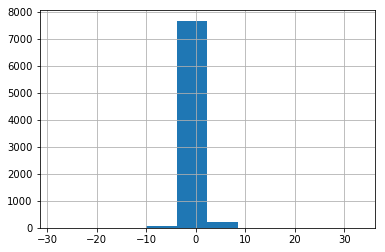

In [235]:
p8=c3['all_crime_slope'].hist()


# Analyze Change in Crime 

## simple RF to see if anything is there

In [374]:
from sklearn import base
import sklearn as sk
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X,y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        if type(X)==pd.DataFrame:
            self.data_frame=X.loc[:,self.col_names]
        else:
            self.data_frame=pd.DataFrame(X).loc[:,self.col_names]
        return self.data_frame

def make_dict_from_list(obj):
    obj_dict={}
    if type(obj) == list:
        for it in obj:
            obj_dict[it] = True
    elif type(obj) == dict:
        for it in obj.items():
            attr = it[0]
            if type(it[1]) == dict:
                for nest_it in it[1].items():
                    obj_dict[attr+'_'+nest_it[0]]=nest_it[1]
            else:
                obj_dict[attr]=it[1]
    else:
        obj_dict[obj]=True
    return obj_dict

from sklearn.feature_extraction import DictVectorizer

class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    def __init__(self,col_names, cat_col_names):
        self.col_names = col_names
        self.cat_col_names=cat_col_names
        self.cont_col_names = [c for c in self.col_names if c not in (cat_col_names)]
    
    def fit(self, X, y=None):
        self.dv_list = []
        self.dv=DictVectorizer(dtype=bool)
        out_frame = X.loc[:,self.cont_col_names].as_matrix()
        for col in self.cat_col_names:
                dv = DictVectorizer(dtype=bool)
                dict_series = X[col].apply(make_dict_from_list)
                hot_code = dv.fit_transform(dict_series).toarray()
                self.dv_list.append(dv)
                out_frame = np.concatenate((out_frame,hot_code), axis = 1)
        return self
    
    def transform(self, X):
        out_frame = X.loc[:,self.cont_col_names].as_matrix()
        for i,col in enumerate(self.cat_col_names):
                dict_series = X[col].apply(make_dict_from_list)
                hot_code = self.dv_list[i].transform(dict_series).toarray()
                out_frame = np.concatenate((out_frame,hot_code), axis = 1)
        return out_frame

    

In [375]:
target = c3['all_crime_slope']
predictor_cols = ['housing_class', 'vac_parcels', 'med_res_sale_price', 'var_res_sale_price', 'Zoning', 'ent_zone',
                  'vacant_buildings', 'percent_owner_occupied', 'vegetated', 'strip_clubs', 'bars',
                  'rest_and_brewery', 'liquor_store', 'all_liquor_licenses'] + perm_cols
cat_cols = ['housing_class', 'Zoning']
for col in predictor_cols:
    c3[col]=c3[col].fillna(0)
                  

In [376]:
out_frame = c3.loc[:,predictor_cols[10:30]].as_matrix()
dict_series = c3['Zoning'].apply(make_dict_from_list)
hot_code = DictVectorizer().fit_transform(dict_series).toarray()

In [377]:
f2=DictEncoder(predictor_cols, cat_cols).fit_transform(c3)

('housing_class', (7961, 9), (7961, 47))
('Zoning', (7961, 49), (7961, 56))


In [386]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.pipeline import Pipeline

cv=model_selection.KFold(n_splits=10,shuffle=True)

linear_pipe = Pipeline([('cst',cst),
                      ('dv',dv),
                      ('rf',RandomForestRegressor(n_estimators = 50))])
lp = linear_pipe.set_params(cst__col_names = predictor_cols,
                                     dv__col_names = predictor_cols,
                                     dv__cat_col_names = ['Zoning', 'housing_class'],
                                     rf__n_estimators = 50) 

gscv=GridSearchCV(lp,cv=cv, param_grid={'rf__max_depth':np.linspace(10,20,11),
                                        },
                                         n_jobs=8,scoring='r2')
gscv.fit(c3, target)


('Zoning', (7164, 49), (7164, 47))
('housing_class', (7164, 9), (7164, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7165, 49), (7165, 47))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7165, 49), (7165, 47))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7165, 48), (7165, 47))
('housing_class', (7165, 9), (7165, 95))
('Zoning', (797, 49), (797, 47))
('housing_class', (797, 9), (797, 96))
('Zoning', (7164, 49), (7164, 47))
('Zoning', (796, 49), (796, 47))
('housing_class', (796, 9), (796, 96))
('housing_class', (7164, 9), (7164, 96))
('Zoning', (7165, 49), (7165, 47))
('Zoning', (796, 49), (796, 47))
('housing_class', (796, 9), (796, 96))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7165, 49), (

('Zoning', (796, 49), (796, 47))
('housing_class', (796, 9), (796, 96))
('Zoning', (7165, 49), (7165, 47))
('Zoning', (796, 48), (796, 47))
('housing_class', (796, 9), (796, 95))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (796, 49), (796, 47))
('housing_class', (796, 9), (796, 96))
('Zoning', (7165, 48), (7165, 47))
('Zoning', (796, 49), (796, 47))
('housing_class', (7165, 9), (7165, 95))
('housing_class', (796, 9), (796, 96))
('Zoning', (7165, 49), (7165, 47))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (796, 49), (796, 47))
('housing_class', (796, 9), (796, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7165, 49), (7165, 47

('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (796, 49), (796, 47))
('housing_class', (796, 9), (796, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (796, 49), (796, 47))
('housing_class', (796, 9), (796, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (7164, 49), (7164, 47))
('housing_class', (7164, 9), (7164, 96))
('Zoning', (796, 49), (796, 47))
('housing_class', (796, 9), (796, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
('Zoning', (796, 49), (796, 47))
('housing_class', (796, 9), (796, 96))
('Zoning', (796, 49), (796, 47))
('housing_class', (796, 9), (796, 96))
('Zoning', (796, 49), (796, 47))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (796, 9), (796, 96))
('Zoning', (7165, 49), (7165, 47))
('housing_class', (7165, 9), (7165, 96))
(

('Zoning', (7961, 49), (7961, 47))
('housing_class', (7961, 9), (7961, 96))


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(steps=[('cst', ColumnSelectTransformer(col_names=['housing_class', 'vac_parcels', 'med_res_sale_price', 'var_res_sale_price', 'Zoning', 'ent_zone', 'vacant_buildings', 'percent_owner_occupied', 'vegetated', 'strip_clubs', 'bars', 'rest_and_brewery', 'liquor_store', 'all_liquor_licenses', 'total_perm...timators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'rf__max_depth': array([ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [387]:
gscv.cv_results_

{'mean_fit_time': array([  6.49713352,   7.06806812,   7.77169456,   8.20495491,
          9.22520094,   9.8521662 ,  10.46955557,  10.83284614,
         12.18821633,  11.81751852,  10.565891  ]),
 'mean_score_time': array([ 0.11175318,  0.13860412,  0.15139353,  0.13175783,  0.15559037,
         0.12960453,  0.15619464,  0.12807837,  0.18547835,  0.11987364,
         0.10027871]),
 'mean_test_score': array([-0.05044075, -0.07843135, -0.06104229, -0.07316775, -0.08147106,
        -0.05670149, -0.07678756, -0.07819363, -0.08424346, -0.07295508,
        -0.09812178]),
 'mean_train_score': array([ 0.38721534,  0.41858717,  0.44805565,  0.47349081,  0.50574373,
         0.52306804,  0.54844783,  0.56995487,  0.58696152,  0.61171316,
         0.62217902]),
 'param_rf__max_depth': masked_array(data = [10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': ({'rf__max

## Exploratory Plots

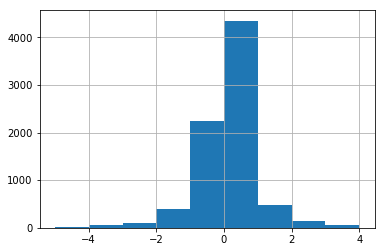

In [393]:
c3['all_crime_slope'].hist(bins=range(-5,5,1))

(-3, 3)

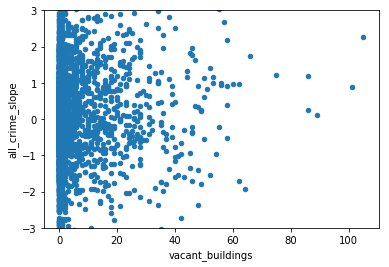

In [434]:
p9=c_filt.plot.scatter(x='vacant_buildings', y='all_crime_slope')
#p9.semilogx()
#p9.set_xlim(10**3, 10**6)
p9.set_ylim(-3,3)

In [430]:
c_filt = c3.loc[c3['vegetated'] == False, :] 

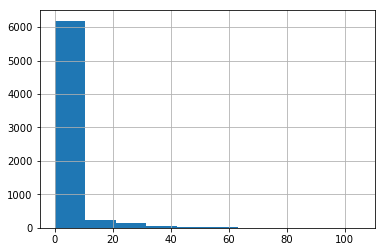

In [436]:
c_filt['vacant_buildings'].hist()

## Consider Autocorrelation

### make dataframe into GEOPANDAS

In [5]:
c3['all'] = (c3['all_crime'] + c3['all_crime_2013'] +
             c3['all_crime_2014'] + c3['all_crime_2015'] + c3['all_crime_2016'] + c3['all_crime_2017'])
c_filt = c3.loc[c3['all']>0 , :]

In [6]:
point_list=[]
for point in c_filt.iterrows():
    point_list.append(geom.Point(point[1]['lon'], point[1]['lat']))

In [7]:
import geopandas as gpd

In [8]:
crime_gpd = gpd.GeoDataFrame(c_filt, geometry = point_list)

### Explore autospatial correlation

In [9]:
import pysal as ps

In [69]:
kw = ps.weights.DistanceBand.from_dataframe(crime_gpd, 11*lon_step, alpha = -1.0, binary=False)
kw.transform = 'r'

In [14]:
Moran_2017= ps.Moran(np.log(crime_gpd['all_crime_2017']+1),kw)

In [15]:
Moran_2017.I

0.33059191507535579

In [16]:
Moran_2012= ps.Moran(crime_gpd['ln_all_crime_2012'],kw)

KeyError: 'ln_all_crime_2012'

In [930]:
Moran_2012.I

0.37028646278906024

In [978]:
sum(np.isnan(ps.lag_spatial(kw, crime_gpd['ln_all_crime_2012'])))

0

### Transform Data for regression

In [18]:
crime_gpd['total_permit_cost_2012'] = crime_gpd['total_permit_cost']
crime_gpd['res_permit_cost_2012'] = crime_gpd['res_permit_cost']
crime_gpd['vac_permit_cost_2012'] = crime_gpd['vac_permit_cost']
crime_gpd['vac_res_permit_cost_2012'] = crime_gpd['vac_res_permit_cost']

In [19]:
crime_gpd['vac_permit_cost'] = (crime_gpd['vac_permit_cost_2012'] + crime_gpd['vac_permit_cost_2013'] +
                                  crime_gpd['vac_permit_cost_2014'] + crime_gpd['vac_permit_cost_2015'] +
                                  crime_gpd['vac_permit_cost_2016'] + crime_gpd['vac_permit_cost_2017'])

In [20]:
crime_gpd['res_permit_cost'] = (crime_gpd['res_permit_cost_2012'] + crime_gpd['res_permit_cost_2013'] +
                                  crime_gpd['res_permit_cost_2014'] + crime_gpd['res_permit_cost_2015'] +
                                  crime_gpd['res_permit_cost_2016'] + crime_gpd['res_permit_cost_2017'])

In [21]:
crime_gpd['demolition_permits'] = (crime_gpd['demoliton_permits_2012'] + crime_gpd['demoliton_permits_2013'] +
                                  crime_gpd['demoliton_permits_2014'] + crime_gpd['demoliton_permits_2015'] +
                                  crime_gpd['demoliton_permits_2016'] + crime_gpd['demoliton_permits_2017'])

In [22]:
crime_gpd['ln_all_crime_2017'] = np.log(crime_gpd['all_crime_2017'].fillna(0) +1)
crime_gpd['ln_all_crime_2016'] = np.log(crime_gpd['all_crime_2016'].fillna(0) +1)
crime_gpd['ln_all_crime_2015'] = np.log(crime_gpd['all_crime_2015'].fillna(0) +1)
crime_gpd['ln_all_crime_2014'] = np.log(crime_gpd['all_crime_2014'].fillna(0) +1) 
crime_gpd['ln_all_crime_2013'] = np.log(crime_gpd['all_crime_2013'].fillna(0) +1)
crime_gpd['ln_all_crime_2012'] = np.log(crime_gpd['all_crime'].fillna(0) + 1)
crime_gpd['strip_clubs'] = crime_gpd['strip_clubs'].fillna(0)
crime_gpd['all_liquor_licenses'] = crime_gpd['all_liquor_licenses'].fillna(0)
crime_gpd['total_permit_cost'] = np.log(crime_gpd['total_permit_cost'].fillna(0)+1)
crime_gpd['vac_permit_cost'] = np.log(crime_gpd['vac_permit_cost'].fillna(0)+1)
crime_gpd['res_permit_cost'] = np.log(crime_gpd['res_permit_cost'].fillna(0)+1)
crime_gpd['med_res_sale_price'] = np.log(crime_gpd['med_res_sale_price'].fillna(
    np.mean(crime_gpd['med_res_sale_price']))+1)

In [23]:
crime_gpd['var_res_sale_price'] = crime_gpd['var_res_sale_price'].fillna(
 np.mean(crime_gpd['var_res_sale_price']))

### Find best spacial parameter for crime2012, autocorrelation

In [61]:
from sklearn import base
class SpatLagTransform(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, column, order, lag):
        self.column = column
        self.order = order
        self.lag = lag
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        print('a')
        self.weights = ps.weights.DistanceBand.from_dataframe(X, self.lag, alpha = self.order, binary = False)
        self.weights.transform = 'r'
        a =ps.lag_spatial(self.weights, X[self.column]).reshape(X.shape[0],1)
        return np.concatenate([X.loc[:,[self.column]].as_matrix(),a], axis = 1)
from sklearn.model_selection import KFold, GridSearchCV
cv = KFold(n_splits=10,shuffle=True)

In [37]:
#crime_gpd = crime_gpd.reset_index()
slt = SpatLagTransform('ln_all_crime_2016', -2, 5*lon_step)
f1= slt.fit_transform(crime_gpd)


In [30]:
crime_gpd.shape

(3846, 135)

In [36]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(crime_gpd.loc[:,['ln_all_crime_2016']].as_matrix(),crime_gpd.loc[:,['ln_all_crime_2016']].as_matrix())
lr.score(crime_gpd.loc[:,['ln_all_crime_2016']].as_matrix(), crime_gpd.loc[:,['ln_all_crime_2017']].as_matrix())

0.57954230885667468

In [38]:
lr = LinearRegression()
lr.fit(f1,crime_gpd.loc[:,['ln_all_crime_2017']].as_matrix())
lr.score(f1, crime_gpd.loc[:,['ln_all_crime_2017']].as_matrix())

0.63402986913625403

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import model_selection

slt =SpatLagTransform('ln_all_crime_2012', -1, 10)
pipe1 = Pipeline([('slt', slt),
                   ('linreg',LinearRegression())])

cv_scores = []
for lag in range(8,12):
    r2 = model_selection.cross_val_score(
            pipe1.set_params(slt__column = 'ln_all_crime_2016', slt__order = -1, slt__lag = lag*lon_step),
            crime_gpd,crime_gpd.loc[:,['ln_all_crime_2017']].as_matrix(),cv=cv)
    cv_scores.append(r2.mean())


a
a
('WARNING: ', 3107, ' is an island (no neighbors)')
('WARNING: ', 7884, ' is an island (no neighbors)')
a


/opt/conda/lib/python2.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 3107, 7884
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


a
('WARNING: ', 2267, ' is an island (no neighbors)')
('WARNING: ', 6714, ' is an island (no neighbors)')
a


/opt/conda/lib/python2.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 2267, 6714
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


a
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 2511, ' is an island (no neighbors)')
a


/opt/conda/lib/python2.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 2, 2511
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


a


/opt/conda/lib/python2.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 7641, 2514
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 2514, ' is an island (no neighbors)')
('WARNING: ', 7641, ' is an island (no neighbors)')
a
a
a
a
a
a
('WARNING: ', 4234, ' is an island (no neighbors)')
('WARNING: ', 6539, ' is an island (no neighbors)')
('WARNING: ', 7795, ' is an island (no neighbors)')
a


/opt/conda/lib/python2.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 4234, 6539, 7795
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


a
('WARNING: ', 6358, ' is an island (no neighbors)')
a
a
('WARNING: ', 3111, ' is an island (no neighbors)')
a
a
('WARNING: ', 2433, ' is an island (no neighbors)')
a
a
a
a
a
a
('WARNING: ', 2435, ' is an island (no neighbors)')
a


/opt/conda/lib/python2.7/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 2435
  warnings.warn("Island id: %s" % str(self.islands[0]))


a
a
a
('WARNING: ', 6539, ' is an island (no neighbors)')
a
a
('WARNING: ', 2349, ' is an island (no neighbors)')
a
a
('WARNING: ', 6714, ' is an island (no neighbors)')
a
a
a
a
a
a
('WARNING: ', 6358, ' is an island (no neighbors)')
a
a
('WARNING: ', 6358, ' is an island (no neighbors)')
a
a
a
a
a
a
('WARNING: ', 6539, ' is an island (no neighbors)')
a
a
('WARNING: ', 6714, ' is an island (no neighbors)')
('WARNING: ', 3194, ' is an island (no neighbors)')
a


/opt/conda/lib/python2.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 6714, 3194
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


a
a
a
('WARNING: ', 2514, ' is an island (no neighbors)')
a
a
('WARNING: ', 2432, ' is an island (no neighbors)')
a


/opt/conda/lib/python2.7/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 2432
  warnings.warn("Island id: %s" % str(self.islands[0]))


a
a
a
a
a
('WARNING: ', 6539, ' is an island (no neighbors)')
a
a
a
a
a
a
('WARNING: ', 6714, ' is an island (no neighbors)')
a
a
a
a
('WARNING: ', 6358, ' is an island (no neighbors)')
a
a
a
a
a
a
a
a


In [94]:
crime_gpd.loc[:,['all_crime_2017','all_crime']].corr()

all_crime_2017  all_crime
all_crime_2017        1.000000   0.706019
all_crime             0.706019   1.000000

In [71]:
Y=np.nan_to_num(crime_gpd['ln_all_crime_2017'].as_matrix().reshape(crime_gpd.shape[0],1))
X=np.nan_to_num(crime_gpd.loc[:,['ln_all_crime_2012','vacant_buildings','strip_clubs',
                  'med_res_sale_price','res_permit_cost','perc_com_ind','vac_permit_cost','bars','liquor_store',
                   'percent_owner_occupied', 'rest_and_brewery','var_res_sale_price','vac_lots']].as_matrix())

sum(np.isnan(X))              

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [87]:

ols=ps.spreg.ML_Lag(Y,X,w=kw,name_y='all_crime_2017', name_x=['ln_all_crime_2012','vacant_buildings','strip_clubs',
                  'med_res_sale_price','res_permit_cost','total_permit_cost','perc_com_ind','vac_permit_cost','bars','liquor_store',
                  'percent_owner_occupied', 'rest_and_brewery','var_res_sale_price'],)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :all_crime_2017                Number of Observations:        3846
Mean dependent var  :      2.2636                Number of Variables   :          15
S.D. dependent var  :      0.8248                Degrees of Freedom    :        3831
Pseudo R-squared    :      0.5494
Spatial Pseudo R-squared:  0.5373
Sigma-square ML     :       0.306                Log likelihood        :   -3185.188
S.E of regression   :       0.554                Akaike info criterion :    6400.377
                                                 Schwarz criterion     :    6494.198

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------

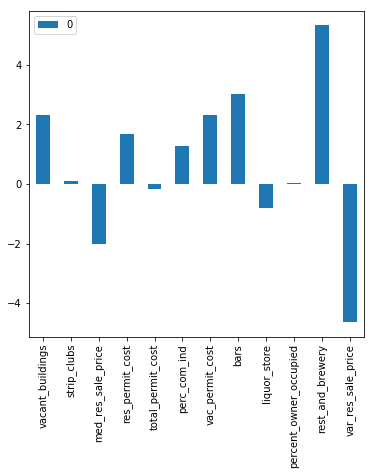

In [92]:
f = plt.figure(figsize=(20,20))
z=pd.DataFrame(ols.z_stat)
z.index = ols.name_x
a = z.iloc[2:-1,[0]].plot.bar(figsize=(6,6))
f.show()

In [503]:
crime_gpd.columns.tolist()

['lat',
 'lon',
 'CFC1214_CI',
 'residential_sales',
 'vac_parcels',
 'vac_lots',
 'housing_class',
 'HuSQmi14CI',
 'I',
 'med_res_sale_price',
 'perc_com_ind',
 'percent_owner_occupied',
 'var_res_sale_price',
 'ACRES',
 'Ipark',
 'index',
 'park',
 'Izoning',
 'Zoning',
 'indexzoning',
 'properties',
 'Ient_zone',
 'ent_zone',
 'Ient_zone_ta',
 'targ_ent_zone',
 'Itree',
 'vegetated',
 'total_permit_cost',
 'lat_label',
 'lon_label',
 'total_permit_cost_2013',
 'total_permit_cost_2014',
 'total_permit_cost_2015',
 'total_permit_cost_2016',
 'total_permit_cost_2017',
 'total_permit_cost_2018',
 'res_permit_cost',
 'res_permit_cost_2013',
 'res_permit_cost_2014',
 'res_permit_cost_2015',
 'res_permit_cost_2016',
 'res_permit_cost_2017',
 'res_permit_cost_2018',
 'vac_permit_cost',
 'vac_permit_cost_2013',
 'vac_permit_cost_2014',
 'vac_permit_cost_2015',
 'vac_permit_cost_2016',
 'vac_permit_cost_2017',
 'vac_permit_cost_2018',
 'vac_res_permit_cost',
 'vac_res_permit_cost_2013',
 'vac

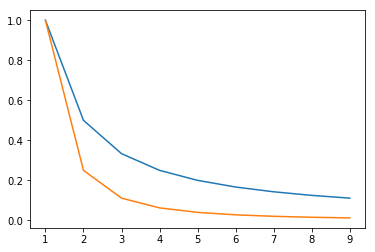

In [837]:
p=range(1,10)
f1=[1.0/p1 for p1 in p]
f2=[1.0/(p1**2) for p1 in p]
plt.plot(p,f1)
plt.plot(p,f2)
plt.show()